In [1]:
import os,sys
sys.path.append('../..')
sys.path.append('../../../gempy/')
import sandbox.sandbox as sb

import gempy as gp
#import gempy_sandbox a   s gpsb
import numpy as np
#from PIL import Image, ImageDraw
import pickle

../../sandbox/sandbox.py:31: RuntimeWarning: Two kernels cannot access the kinect at the same time. This will lead to a sudden death of the kernel. Be sure no other kernel is running before initialize a kinect object.
  'Be sure no other kernel is running before initialize a kinect object.', RuntimeWarning)
../../../gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../../gempy/gempy/data_management.py:34: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')
../../../gempy/gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation poste

### Set up the sandbox 

In [2]:
calibration_filename = "sandbox_brisbane.dat" 

kinect = sb.Kinect(dummy=True)

dummy mode. get_frame() will return a synthetic depth frame, other functions may not work


In [3]:
projector = sb.Projector(resolution = (1024,768))
projector.work_directory ="./temp"
projector.refresh = 100
projector.input_rescale  = False  
calibration = projector.calibration
calibration.load(calibration_file=calibration_filename)

projector.start_stream()          #Open an new Tab with sandbox output.

created new calibration: <sandbox.sandbox.Calibration object at 0x1c255690f0>
calibration data file not found


FileNotFoundError: [Errno 2] No such file or directory: './temp/projector0.html'

### Setup the model

In [3]:

geo_model = gp.load_model('./gempy/notebooks/tutorials/saves/ch1-2.pickle')
scale=sb.Scale(extent=[0,2000,500,1500,1000,3000] , calibration=calibration) #initialize scale object to handle the scaling of the model in the andbox

scale.calculate_scales()

grid = sb.Grid(calibration=calibration,scale=scale)

Aspect ratio of the model is fixed in XY
Model size is limited by X dimension
scale in Model units/ mm (X,Y,Z): [2.0, 2.0262008733624453, 2.6666666666666665]
the shown extent is [0.0, 1995.633187772926, 500.0, 2015.28384279476] 


### set up the visualization

In [4]:
x = range(scale.output_res[0])
y = range(scale.output_res[1])

geol_map = sb.Plot(
    calibration=calibration,
    cmap=gp.plot.cmap,
    norm=gp.plot.norm
    )

fault_line = sb.Contour(
    start=0.5,
    end=2.5,
    step=1.0,
    linewidth=3.0,
    colors=[(1.0, 1.0, 1.0, 1.0)]
    )

main_contours = sb.Contour(
    start=scale.extent[4],
    end=scale.extent[5],
    step=100,
    show_labels=True
    )

sub_contours = sb.Contour(     

    start=scale.extent[4],
    end=scale.extent[5],
    step=25,
    linewidth=0.8,
    colors=[(0, 0, 0, 0.7)],
   )



 

In [5]:
#new structure
def run():
    grid.update_grid(kinect.get_filtered_frame(n_frames=3,sigma_gauss=4))
    sol = gp.compute_model_at(grid.depth_grid, geo_model)

    block = sol.lith_block.reshape((scale.output_res[1], scale.output_res[0]))
    geol_map.render_frame(block)

    elevation = grid.depth_grid.reshape((scale.output_res[1], scale.output_res[0], 3))[:, :, 2]
    #fault_data = sol.fault_blocks.reshape((scalgeol_map.outfilee.output_res[1], scale.output_res[0])) 
    for fault in sol.fault_blocks:
        fault=fault.reshape((scale.output_res[1],scale.output_res[0]))
        geol_map.add_contours(fault_line, [x,y,fault])


    geol_map.add_contours(main_contours,[x,y,elevation])
    geol_map.add_contours(sub_contours,[x,y,elevation])
    geol_map.save(outfile="./temp/current_frame.png")
    projector.show(rescale=False)


KeyboardInterrupt: 

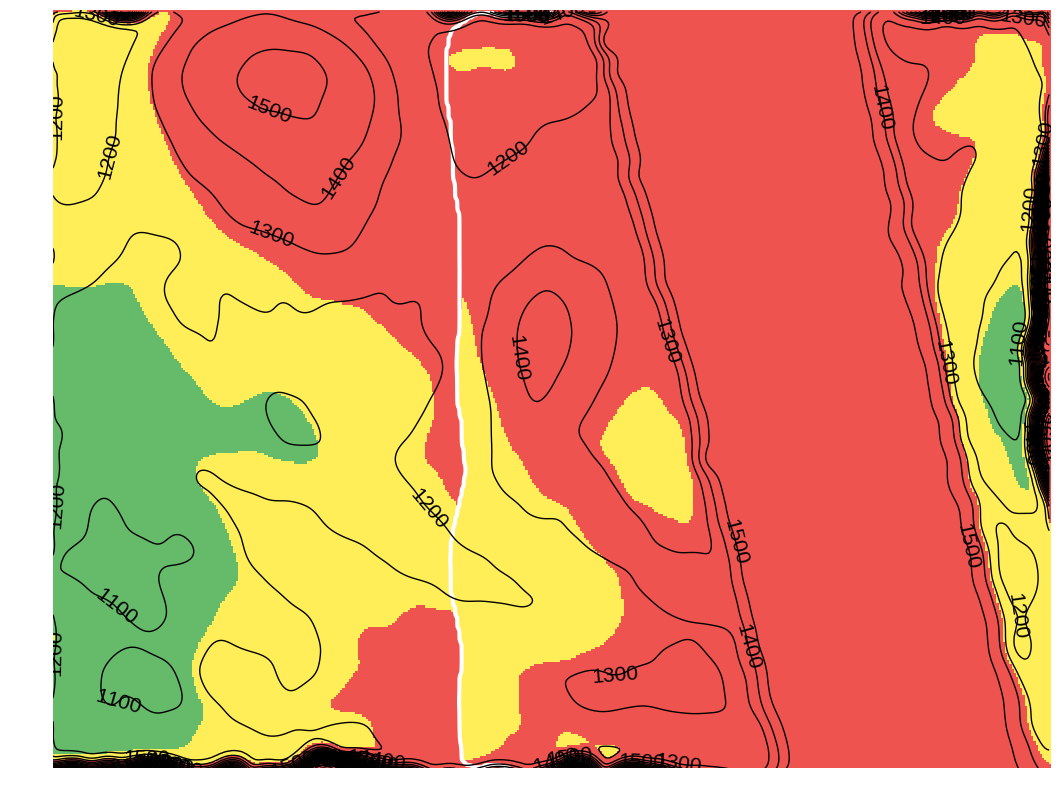

In [10]:
while True:
    run()

In [10]:
projector.start_stream()

In [ ]:
geology.lock.acquire()
print('na')
geology.lock.release()

In [ ]:
fault_line.show=True

x

In [ ]:
kinect.sigma_gauss=7

### Toggle fault visibility

In [ ]:
geology.pause()
if geology.module.show_faults is True:
    geology.module.show_faults = False
else:
    geology.module.show_faults = True
geology.resume()
    

## change contour levels 

In [ ]:
       self.fig = plt.figure(figsize=(self.w, self.h), dpi=100, frameon=False)
        self.ax = plt.Axes(self.fig, [0., 0., 1., 1.])
        self.ax.set_axis_off()
        self.fig.add_axes(self.ax)

geology.pause()
start = 0
end = 2000
main_step = 50
sub_step = 10

geology.module.main_contours = np.arange(start, end, main_step)
geology.module.sub_contours = np.arange(start, end, sub_step)
geology.resume()

In [ ]:
geology.lock.acquire()
geology.lock.release()


In [ ]:
geo_model_3d = gp.load_model('./gempy/notebooks/tutorials/saves/ch1-2.pickle')


In [ ]:
for i in range(10):
    with geology.lock:
        gp.plot.plot_section(geo_model_3d, 10)

In [ ]:
with geology.lock:
    for i in range(10):
        gp.plot.plot_section(geo_model_3d, 10)

In [ ]:
geology.lock.release()

In [ ]:
geology.lock.locked()

In [ ]:
geology.run()

In [ ]:
a = 0
for i in range(100000):
    a += i


In [ ]:
with geology.lock:
    for i in range(10):
        gp.compute_model(geo_model_3d)

In [ ]:
geo_model.interpolator.theano_graph

In [ ]:
for i in range(10):
    gp.compute_model(geo_model_3d)

In [ ]:
geo_model_3d.solutions

In [ ]:
gp.plot.plot_surfaces_3D(geo_model_3d)
